In [1]:
from xflow.extensions.physics.beam import extract_beam_parameters
from xflow.utils.io import scan_files
from xflow.utils.decorator import with_progress
from xflow.data.transform import split_width
from xflow.utils.visualization import plot_image

import matplotlib.pyplot as plt
import cv2

image_shape = []

def get_image_paths(dir):
    image_paths = []
    for d in dir:
        image_paths.extend(scan_files(d, extensions='.png', return_type='str'))
    return image_paths

@with_progress
def run_beam_extraction(image_paths, method='moments'):
    """
    image_paths: list of file paths (str or Path)
    returns: list of whatever extract_beam_parameters returns
    """
    results = []
    for path in image_paths:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # skip unreadable images
        l, r = split_width(img)

        params = extract_beam_parameters(l, method=method)
        if not params:
            continue
        results.append(params)
        
    image_shape.insert(0, l.shape)
    return results



# Wednesday Chromox
# dir = ["/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/12",
#        "/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/11",
#        "/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/10"]
# all_params = run_beam_extraction(get_image_paths(dir), method='moments')




# Friday/Saturday Chromox
dir = ["/Users/andrewxu/Documents/DataHub/datasets/2025-11-21/dataset/",
       "/Users/andrewxu/Documents/DataHub/datasets/2025-11-22-morning/dataset/",
       ]
all_params = run_beam_extraction(get_image_paths(dir), method='moments')




# Sunday Green Laser
# dir = ["C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23-morning\\dataset\\13",
#        "C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23-morning\\dataset\\15",
#        "C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23-morning\\dataset\\16"]

# Sunday YAG
# all_params = run_beam_extraction(get_image_paths(dir), method='moments')
# # load more dataset/batch (YAG real beam data)
# dir = ["C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23\\dataset\\1",
#        "C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23\\dataset\\7"]
# all_params_yag = run_beam_extraction(get_image_paths(dir), method='moments')

100%|██████████| 13977/13977 [07:22<00:00, 31.62it/s]


In [12]:
import numpy as np

def find_best_square(all_params, square_size=0.25):
    """
    Find an axis-aligned square in normalized coordinates that contains
    the maximum number of beam centroids.

    Args:
        all_params: iterable of [h_centroid, v_centroid, h_width, v_width],
                    where h_centroid, v_centroid are in [0, 1] with origin
                    at top-left (0, 0).
        square_size: side length L of the square in normalized units [0, 1].

    Returns:
        {
            "points": [(x_min, y_min), (x_max, y_max)],  # top-left, bottom-right
            "top_left": (x_min, y_min),
            "bottom_right": (x_max, y_max),
            "count": number_of_points_inside
        }
        or None if all_params is empty.
    """
    if not all_params:
        return None

    L = float(square_size)
    if not (0.0 < L <= 1.0):
        raise ValueError("square_size must be in (0, 1].")

    # Take only centroids, clip to [0, 1]
    pts = np.array([[p[0], p[1]] for p in all_params], dtype=float)
    x = np.clip(pts[:, 0], 0.0, 1.0)
    y = np.clip(pts[:, 1], 0.0, 1.0)

    eps = 1e-12
    candidate_x = set()

    # Candidate left edges from points and (point - L), clipped into [0, 1-L]
    for xi in x:
        candidate_x.add(float(np.clip(xi,     0.0, 1.0 - L)))
        candidate_x.add(float(np.clip(xi - L, 0.0, 1.0 - L)))

    candidate_x.add(0.0)
    candidate_x.add(1.0 - L)
    candidate_x = sorted(candidate_x)

    best_count = -1
    best_x0 = 0.0
    best_y0 = 0.0

    for x0 in candidate_x:
        x1 = x0 + L + eps  # small eps so we include points exactly on the right edge
        mask = (x >= x0) & (x <= x1)
        ys = y[mask]
        if ys.size == 0:
            continue

        ys_sorted = np.sort(ys)
        a = 0
        for b in range(ys_sorted.size):
            # shrink vertical window until height <= L
            while ys_sorted[b] - ys_sorted[a] > L + eps:
                a += 1

            # top edge of square in y (remember: y increases downward)
            y0_candidate = ys_sorted[a]

            # ensure bottom edge stays within [0, 1]
            if y0_candidate + L > 1.0:
                y0_candidate = 1.0 - L

            count = b - a + 1
            if count > best_count:
                best_count = count
                best_x0 = x0
                best_y0 = y0_candidate

    x_min = best_x0
    y_min = best_y0
    x_max = min(best_x0 + L, 1.0)
    y_max = min(best_y0 + L, 1.0)

    top_left = (x_min, y_min)         # (x, y) with origin top-left
    bottom_right = (x_max, y_max)     # (x, y) with origin top-left

    return {
        "points": [top_left, bottom_right],
        "top_left": top_left,
        "bottom_right": bottom_right,
        "count": int(best_count),
    }


H, W = image_shape[0]  # e.g. from image_np.shape[:2]

res = find_best_square(all_params, square_size=0.20)
(x_min_n, y_min_n), (x_max_n, y_max_n) = res["points"]

x1 = int(round(x_min_n * W))
y1 = int(round(y_min_n * H))
x2 = int(round(x_max_n * W))
y2 = int(round(y_max_n * H))
coords = [[int(x1), int(y1)], [int(x2), int(y2)]]
print(coords)


775 489 1159 729


In [26]:
import numpy as np

def find_best_square(all_params, square_size=0.25, image_shape=None):
    """
    Find an axis-aligned square (in *pixel* sense) using normalized centroids.

    Args:
        all_params: iterable of [h_centroid, v_centroid, h_width, v_width],
                    where h_centroid, v_centroid are in [0, 1] with origin
                    at top-left (0, 0), normalized by width / height.
        square_size: side length L of the square in *normalized width* units.
                     (0 < L <= 1)
        image_shape: (H, W) of the image. If given, the function ensures that
                     the region is square in pixel space.

    Returns:
        {
            "points": [(x_min, y_min), (x_max, y_max)],  # top-left, bottom-right
            "top_left": (x_min, y_min),
            "bottom_right": (x_max, y_max),
            "count": number_of_points_inside
        }
        or None if all_params is empty.
    """
    if not all_params:
        return None

    L = float(square_size)
    if not (0.0 < L <= 1.0):
        raise ValueError("square_size must be in (0, 1].")

    # aspect factor: convert y from [0,1] (normalized by H) to
    # coords normalized by W so that squares in this space are pixel-squares
    if image_shape is not None:
        H, W = image_shape[:2]
        ratio = H / float(W)      # < 1 for wide images like 1200x1920
    else:
        ratio = 1.0               # fall back to original behaviour

    # Take only centroids, clip to [0, 1]
    pts = np.array([[p[0], p[1]] for p in all_params], dtype=float)
    x = np.clip(pts[:, 0], 0.0, 1.0)
    y = np.clip(pts[:, 1], 0.0, 1.0)

    # Scale y to the same normalization as width (so square in this space => pixel square)
    y_scaled = y * ratio

    eps = 1e-12
    candidate_x = set()

    # Candidate left edges from points and (point - L), clipped into [0, 1-L]
    for xi in x:
        candidate_x.add(float(np.clip(xi,     0.0, 1.0 - L)))
        candidate_x.add(float(np.clip(xi - L, 0.0, 1.0 - L)))

    candidate_x.add(0.0)
    candidate_x.add(1.0 - L)
    candidate_x = sorted(candidate_x)

    best_count = -1
    best_x0 = 0.0
    best_y0_scaled = 0.0

    for x0 in candidate_x:
        x1 = x0 + L + eps  # small eps so we include points exactly on the right edge
        mask = (x >= x0) & (x <= x1)
        ys_s = y_scaled[mask]
        if ys_s.size == 0:
            continue

        ys_sorted = np.sort(ys_s)
        a = 0
        for b in range(ys_sorted.size):
            # shrink vertical window in *scaled* coordinates until height <= L
            while ys_sorted[b] - ys_sorted[a] > L + eps:
                a += 1

            # candidate top edge in scaled coordinates
            y0_s_candidate = ys_sorted[a]

            # ensure bottom edge stays within [0, ratio]
            if y0_s_candidate + L > ratio:
                y0_s_candidate = ratio - L

            count = b - a + 1
            if count > best_count:
                best_count = count
                best_x0 = x0
                best_y0_scaled = y0_s_candidate

    # Convert back to original normalized coordinates
    x_min = best_x0
    x_max = min(best_x0 + L, 1.0)

    if ratio > 0:
        y_min = best_y0_scaled / ratio
        y_max = min((best_y0_scaled + L) / ratio, 1.0)
    else:
        y_min = 0.0
        y_max = L

    top_left = (x_min, y_min)         # (x, y) normalized, origin top-left
    bottom_right = (x_max, y_max)

    return {
        "points": [top_left, bottom_right],
        "top_left": top_left,
        "bottom_right": bottom_right,
        "count": int(best_count),
    }


# Usage example
H, W = image_shape[0]  # e.g. image_np.shape[:2]

res = find_best_square(all_params, square_size=0.12, image_shape=(H, W))
(x_min_n, y_min_n), (x_max_n, y_max_n) = res["points"]

x1 = int(round(x_min_n * W))
y1 = int(round(y_min_n * H))
x2 = int(round(x_max_n * W))
y2 = int(round(y_max_n * H))

coords = [[x1, y1], [x2, y2]]
print(coords)


[[862, 493], [1093, 723]]


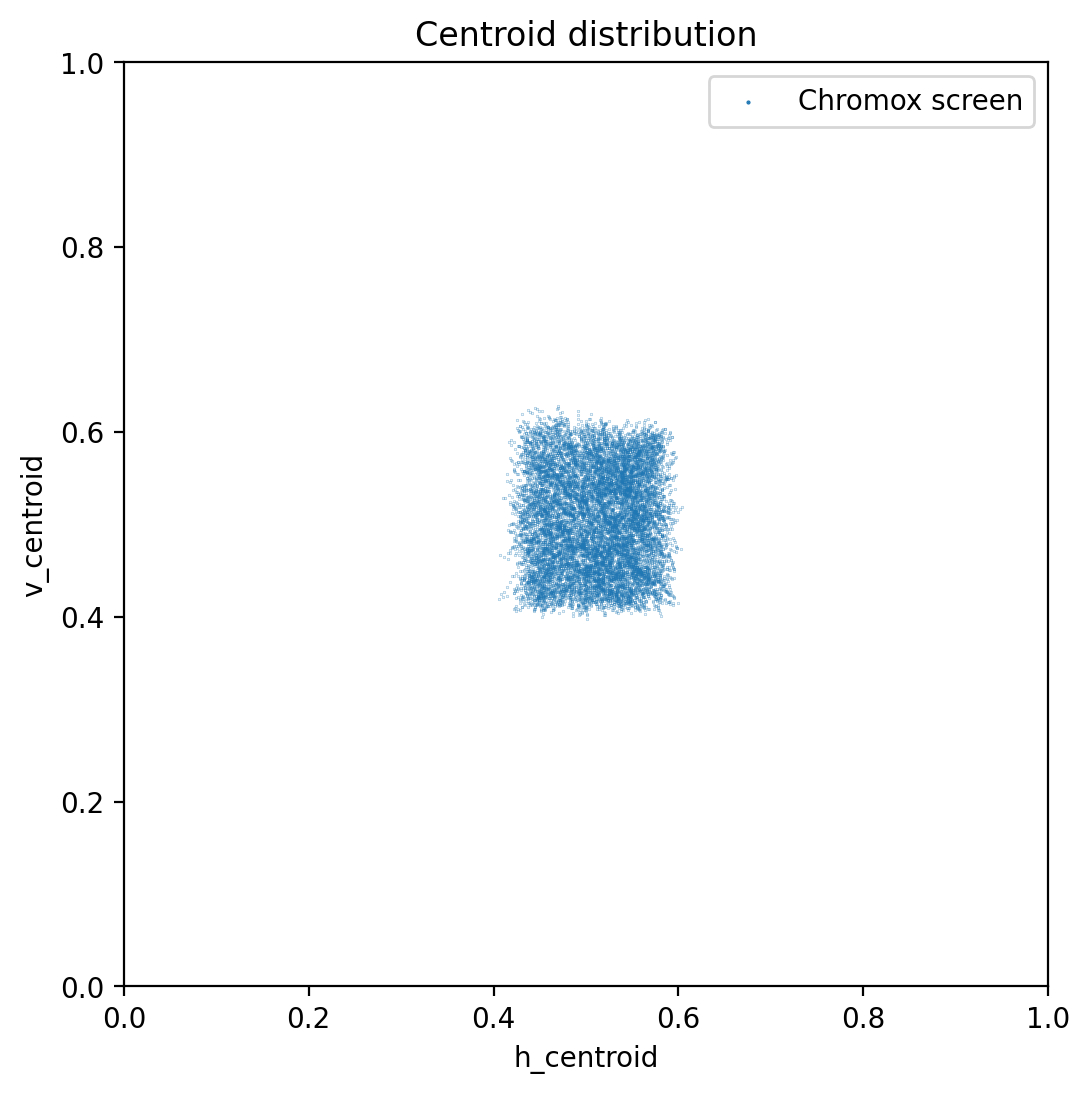

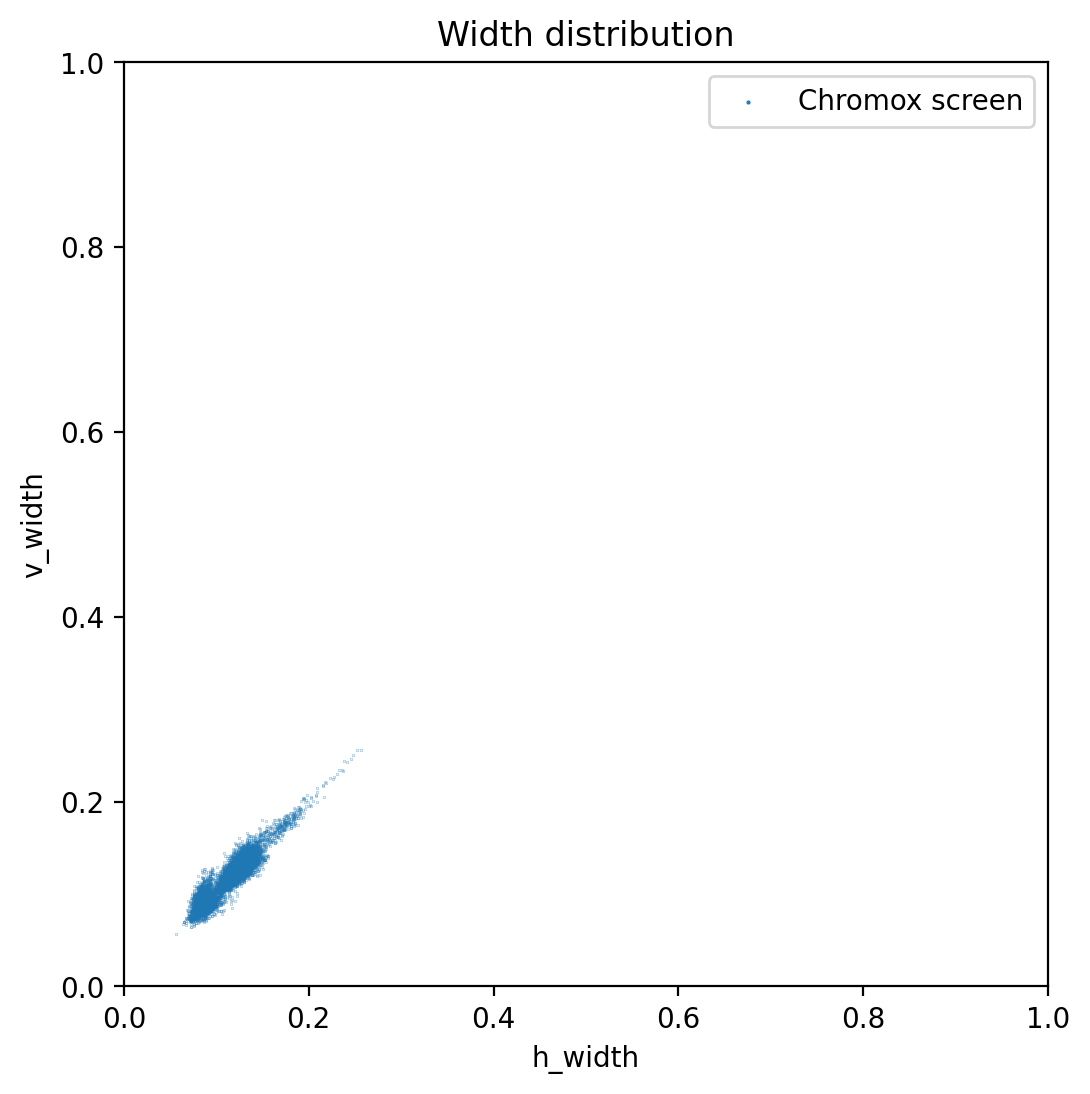

In [41]:
import matplotlib.pyplot as plt

def plot_beam_parameters(
    all_params,
    point_size=1,
    top_left=None,
    bottom_right=None,
    dpi=200,
    figsize=(5, 5),
    names=None,        # legend labels when multiple datasets
    markerscale=1,
    image_shape=None,  # (height, width) in pixels
):
    """
    all_params:
        - single dataset: list of [h_centroid, v_centroid, h_width, v_width]
        - multiple datasets: list of such lists, one per source
    names:
        - list of legend labels, same length as all_params, used only
          when multiple datasets are passed.
    top_left, bottom_right:
        - given in *pixel* coordinates if image_shape is not None
          top_left     = (x_min, y_max)
          bottom_right = (x_max, y_min)
    image_shape:
        - (height, width) of the image in pixels
        - if given, h_centroid and v_centroid are assumed normalized [0,1]
          and are rescaled to pixel units.
    """

    # Normalize input to a list of (label, dataset)
    if names is None:
        # single dataset, no legend
        groups = [("data", all_params)]
        use_legend = False
    else:
        if len(names) != len(all_params):
            raise ValueError("len(names) must match len(all_params) when multiple datasets are given.")
        groups = list(zip(names, all_params))
        use_legend = True

    # ============================
    # 1) Centroid distribution
    # ============================
    fig1, ax1 = plt.subplots(figsize=figsize, dpi=dpi)

    for label, params in groups:
        h_centroid = [p[0] for p in params]
        v_centroid = [p[1] for p in params]

        # If image_shape is given, convert normalized [0,1] -> pixel units
        if image_shape is not None:
            h_px = [x * image_shape[1] for x in h_centroid]  # width
            v_px = [y * image_shape[0] for y in v_centroid]  # height
        else:
            h_px = h_centroid
            v_px = v_centroid

        if use_legend:
            ax1.scatter(h_px, v_px, s=point_size, label=label)
        else:
            ax1.scatter(h_px, v_px, s=point_size)

    ax1.set_xlabel("h_centroid")
    ax1.set_ylabel("v_centroid")
    ax1.set_title("Centroid distribution")

    # Axis limits: pixel space if image_shape is given, otherwise [0,1]
    if image_shape is not None:
        ax1.set_xlim(0, image_shape[1])  # width
        ax1.set_ylim(0, image_shape[0])  # height
    else:
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)

    ax1.set_aspect('equal', adjustable='box')

    # Rectangle in pixel coordinates (if provided)
    if top_left is not None and bottom_right is not None:
        x_min, y_max = top_left
        x_max, y_min = bottom_right
        width  = x_max - x_min
        height = y_max - y_min

        rect = plt.Rectangle(
            (x_min, y_min),  # bottom-left corner in data coords
            width,
            height,
            fill=False,
            linestyle='--',
            edgecolor='red'
        )
        ax1.add_patch(rect)

    if use_legend:
        ax1.legend(markerscale=markerscale)
        
    # plt.grid()

    # ============================
    # 2) Width distribution (still normalized)
    # ============================
    fig2, ax2 = plt.subplots(figsize=figsize, dpi=dpi)
    for label, params in groups:
        h_width = [p[2] for p in params]
        v_width = [p[3] for p in params]
        if use_legend:
            ax2.scatter(h_width, v_width, s=point_size, label=label)
        else:
            ax2.scatter(h_width, v_width, s=point_size)

    ax2.set_xlabel("h_width")
    ax2.set_ylabel("v_width")
    ax2.set_title("Width distribution")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_aspect('equal', adjustable='box')

    if use_legend:
        ax2.legend(markerscale=markerscale)

    plt.show()


# plot_beam_parameters(
#     [all_params],                 # list of datasets (here only one)
#     names=["Chromox screen"],
#     point_size=0.01,
#     top_left=coords[0],     # already in pixel coords now
#     bottom_right=coords[1],
#     dpi=200,
#     figsize=(6, 6),
#     markerscale=5,
#     image_shape=image_shape[0],     # (height, width)
# )



top_left = [750, 400]
x = 1200-top_left[0]
bottom_right = [1200, top_left[1] + x]

plot_beam_parameters(
    [all_params],                 # list of datasets (here only one)
    names=["Chromox screen"],
    point_size=0.01,
    top_left=top_left,     # already in pixel coords now
    bottom_right=bottom_right,
    dpi=200,
    figsize=(6, 6),
    markerscale=5,
    image_shape=(1, 1),     # (height, width). image_shape[0]
) 

In [33]:
coords

[[862, 493], [1093, 723]]

In [19]:
res["top_left"]

(0.4035471664463018, np.float64(0.40737901758412437))